In [1]:
!pip install chess

In [1]:
import os  # Import the os module for interacting with the operating system
import chess  # Import the chess library for chess-related functionalities
import chess.pgn  # Import the PGN module from chess library to parse PGN files
import chess.engine  # Import the chess.engine module for chess engine interaction
import random  # Import the random module for generating random numbers
import time  # Import the time module for time-related functionalities
from math import log, sqrt, e, inf  # Import specific functions/constants from the math module
from IPython.display import display, clear_output  # Import display and clear_output functions from IPython.display module
from tqdm import tqdm  # Import tqdm for displaying progress bars
import numpy as np  # Import NumPy for numerical computing
import matplotlib.pyplot as plt  # Import matplotlib for plotting

In [2]:
scores = {
    'p': -1,     # Score for a black pawn
    'n': -3,     # Score for a black knight
    'b': -3,     # Score for a black bishop
    'r': -5,     # Score for a black rook
    'q': -9,     # Score for a black queen
    'k': -10**5, # Score for a black king
    'P': 1,      # Score for a white pawn
    'N': 3,      # Score for a white knight
    'B': 3,      # Score for a white bishop
    'R': 5,      # Score for a white rook
    'Q': 9,      # Score for a white queen
    'K': 10**5   # Score for a white king
}

In [3]:
!pwd
!ls

/home/mahmud/Labs/AILAB/Lab02
A2roll_20_alpha_beta.ipynb  A2roll_20_MCTS.ipynb  stockfish


In [8]:
def load_engine():
    file_name = 'stockfish-ubuntu-x86-64'
    return chess.engine.SimpleEngine.popen_uci(os.path.abspath('stockfish/'+file_name))

In [4]:
def evaluate(fen):
    global scores  # Access the global variable 'scores'
    sc = 0  # Initialize the score variable
    
    # Iterate through each character in the FEN string
    for i in fen:
        if(i not in scores):  # Check if the character represents a chess piece
            continue  # If not a chess piece, skip to the next character
        
        sc += scores[i]  # Add the score of the chess piece to the total score
    
    return sc  # Return the total score


In [5]:
def minimax(tmp_board, all_moves, white, over, depth, alpha=-10**5-5, beta=10**5+5):
    fen = tmp_board.fen()  # Get the FEN representation of the current board position
    
    # Base case: If game is over or reached maximum depth, return the evaluation of the position
    if over or depth == 0:
        if over:
            # Check if the game is over and return the evaluation accordingly
            if tmp_board.result()[0] == '1':
                return (tmp_board, 10**5 + 1, '')
            elif tmp_board.result()[-1] == '1':
                return (tmp_board, -10**5 - 1, '')
            else:
                return (tmp_board, 0, '')
        
        # If not over, evaluate the current position
        if white:
            # If it's white's turn, maximize the score
            mx = -10**5
            move = ''
            for i in all_moves:
                tmp_board.push_san(i)
                val = evaluate(tmp_board.fen().split()[0])  # Evaluate the position
                if mx < val:
                    mx = val
                    move = i
                alpha = max(alpha, mx)
                if beta <= alpha:
                    tmp_board = chess.Board(fen)
                    break
                tmp_board = chess.Board(fen)
            return (tmp_board, mx, move)
        else:
            # If it's black's turn, minimize the score
            mn = 10**5
            move = ''
            for i in all_moves:
                tmp_board.push_san(i)
                val = evaluate(tmp_board.fen().split()[0])  # Evaluate the position
                if mn > val:
                    mn = val
                    move = i
                beta = min(beta, mn)
                if beta <= alpha:
                    tmp_board = chess.Board(fen)
                    break
                tmp_board = chess.Board(fen)
            return (tmp_board, mn, move)
    
    # Recursive case: Perform minimax search with alpha-beta pruning
    if white:
        mx = -10**6
        move = ''
        for i in all_moves:
            tmp_board.push_san(i)
            tmp_all_moves = [tmp_board.san(i) for i in list(tmp_board.legal_moves)]
            val = minimax(tmp_board, tmp_all_moves, 0, tmp_board.is_game_over(), depth-1, alpha, beta)
            if mx < val[1]:
                mx = val[1]
                move = i
            tmp_board = chess.Board(fen)
            alpha = max(alpha, mx)
            if beta <= alpha:
                tmp_board = chess.Board(fen)
                break
            tmp_board = chess.Board(fen)
        return (tmp_board, mx, move)
    else:
        mn = 10**6
        move = ''
        for i in all_moves:
            tmp_board.push_san(i)
            tmp_all_moves = [tmp_board.san(i) for i in list(tmp_board.legal_moves)]
            val = minimax(tmp_board, tmp_all_moves, 1, tmp_board.is_game_over(), depth-1, alpha, beta)
            if mn > val[1]:
                mn = val[1]
                move = i
            tmp_board = chess.Board(fen)
            beta = min(beta, mn)
            if beta <= alpha:
                tmp_board = chess.Board(fen)
                break
            tmp_board = chess.Board(fen)
        return (tmp_board, mn, move)


In [6]:
def run(depth=1):
    avg_t = []  # List to store the average time taken per move
    board = chess.Board()  # Initialize a chess board
    engine = load_engine()  # Load a chess engine
    white = 1  # Flag to indicate whether it's white's turn (1) or black's turn (0)
    moves = 0  # Counter to keep track of the number of moves made
    pgn = []  # List to store the moves in Portable Game Notation (PGN) format
    game = chess.pgn.Game()  # Initialize a chess game object
    evaluations = []  # List to store evaluations of board positions
    
    sm = 0  # Variable to store the sum of time taken per move
    cnt = 0  # Counter to keep track of the number of moves made
    
    itr = 5  # Number of iterations/games to play
    board
    
    # Loop through the iterations/games
    for _ in tqdm(range(itr)):
        if(board.is_game_over()):  # Check if the game is over
            break
        
        start = time.time()  # Record the start time for measuring the time taken per move
        cnt += 1  # Increment the move counter
        
        all_moves = [board.san(i) for i in list(board.legal_moves)]  # Get all legal moves in SAN format
        
        if(white):
            # If it's white's turn, use minimax algorithm to find the best move
            result = minimax(board, all_moves, white, board.is_game_over(), depth)
            board = result[0]  # Update the board after making the move
            pgn.append(result[2])  # Add the move to the PGN list
            board.push_san(result[2])  # Make the move on the board
            white ^= 1  # Switch turns
        else:
            # If it's black's turn, use minimax algorithm to find the best move
            result = minimax(board, all_moves, white, board.is_game_over(), depth)
            board = result[0]  # Update the board after making the move
            pgn.append(result[2])  # Add the move to the PGN list
            board.push_san(result[2])  # Make the move on the board
            white ^= 1  # Switch turns
        
        moves += 1  # Increment the move counter
        board_evaluation = evaluate(board.fen().split()[0])  # Evaluate the current board position
        evaluations.append(board_evaluation)  # Add the evaluation to the evaluations list
        t = time.time() - start  # Calculate the time taken for this move
        sm += t  # Add the time taken to the sum
        avg_t.append(t)  # Add the time taken to the average time list
        clear_output(wait=True)  # Clear the output to update the display
        
        print(result[2])  # Print the move made
        print(board)  # Print the current board position
    
    clear_output(wait=True)  # Clear the output
    
    print("Average Time per move = ", sm / cnt)  # Print the average time taken per move
    print(board)  # Print the final board position
    print(" ".join(pgn))  # Print the moves in PGN format
    print()
    print(evaluations)  # Print the evaluations of board positions
    print(board.result())  # Print the result of the game
    
    game.headers["Result"] = board.result()  # Set the game result in the headers
    #print(game)
    engine.quit()  # Quit the chess engine
    return avg_t  # Return the average time per move list


In [9]:
depth_time = []  # List to store the average time taken per move for different depths

# Loop through depths from 1 to 4
for i in range(4):
    print(f'Depth{i+1}')  # Print the depth being evaluated
    depth_time.append(run(i+1))  # Run the game for the current depth and append the result to depth_time


Average Time per move =  17.139430809020997
r n b q k b . r
p p p p p p . p
. . . . . . p n
. . . . . . . .
. . . . . . . .
. . . . . . P .
P P P P P P . P
R N B Q K B N R
g3 g6 Nh3 Nh6 Ng1

[0, 0, 0, 0, 0]
*


In [ ]:
depth_time

In [65]:
x_coords = range(1, len(depth_time[0])+1)

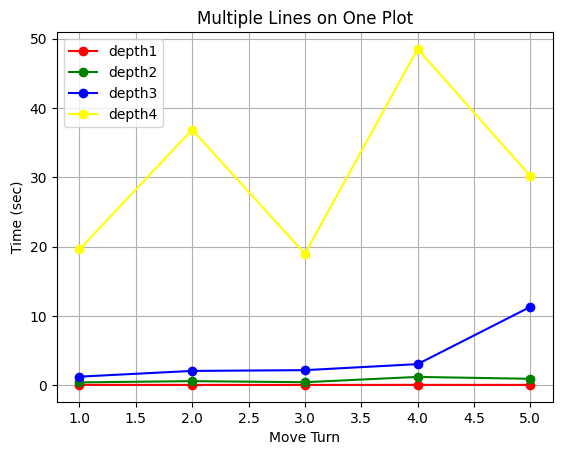

In [66]:
color = ['red', 'green', 'blue', 'yellow', 'black']

for i in range(len(depth_time)):
    plt.plot(x_coords, depth_time[i], label=f'depth{i+1}', color=color[i], linestyle='-', marker='o')

plt.title('Multiple Lines on One Plot')
plt.ylabel('Time (sec)')
plt.xlabel('Move Turn')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()